=== Key Customer Metrics ===
Total Customers: 4
High-Churn Customers: 3
Average Spend: 1162.5

Customer Data Sample:


,customer_id,name,last_purchase_date,total_spent,total_orders,Recency,Segment,Churn_Risk
0,1,Alice,2025-03-15,1200,5,182,Medium,High
1,2,Bob,2025-08-01,450,2,43,Low,Low
2,3,Charlie,2024-12-20,2200,10,267,High,High
3,4,David,2025-01-05,800,3,251,Medium,High


=== High-Risk Transactions ===


,transaction_id,customer_id,amount,date,Risk_Flag
2,3,3,60000,2025-01-10,High


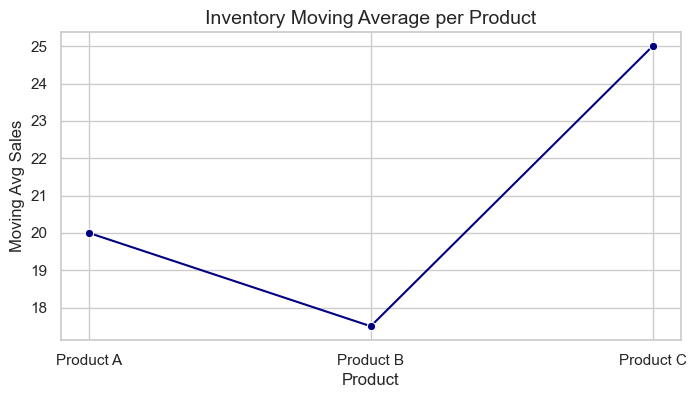

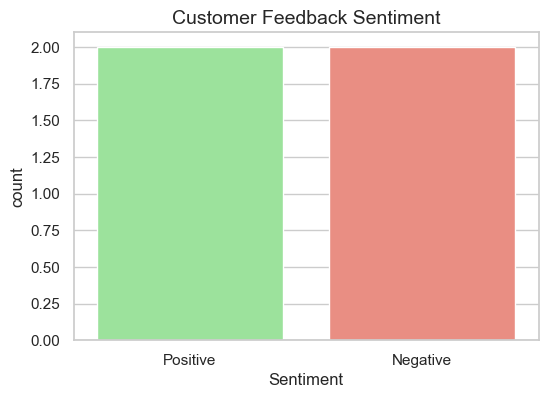

interactive(children=(Dropdown(description='segment', options=('Low', 'Medium', 'High'), value='Low'), Output(…

interactive(children=(IntSlider(value=180, description='days', max=365, min=30, step=30), Output()), _dom_clas…

interactive(children=(Dropdown(description='product_name', options=('Product A', 'Product B', 'Product C'), va…

interactive(children=(IntSlider(value=46000, description='threshold', max=100000, min=1000, step=5000), Output…

interactive(children=(Dropdown(description='sentiment', options=('Positive', 'Negative'), value='Positive'), O…

<function __main__.show_feedback(sentiment)>

In [3]:
# ===========================
# SmartBiz Dashboard
# Author: Nani Mattegunta
# Purpose: Customer Analytics, Transactions Risk, Inventory Trends, Feedback Sentiment
# Features: Interactive filters using ipywidgets, professional visualizations, portfolio-ready
# ===========================

# 0️⃣ Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from ipywidgets import interact
from IPython.display import display
%matplotlib inline

sns.set(style="whitegrid")  # professional plot style

# ===========================
# 1️⃣ Sample Data
# ===========================

# Customers
customers = pd.DataFrame({
    'customer_id':[1,2,3,4],
    'name':['Alice','Bob','Charlie','David'],
    'last_purchase_date':['2025-03-15','2025-08-01','2024-12-20','2025-01-05'],
    'total_spent':[1200,450,2200,800],
    'total_orders':[5,2,10,3]
})

# Transactions
transactions = pd.DataFrame({
    'transaction_id':[1,2,3,4],
    'customer_id':[1,2,3,4],
    'amount':[500,450,60000,1500],
    'date':['2025-03-16','2025-08-02','2025-01-10','2025-01-06']
})

# Inventory
inventory = pd.DataFrame({
    'product_id':[1,2,3],
    'product_name':['Product A','Product B','Product C'],
    'stock_qty':[100,50,200],
    'weekly_sales':[20,15,40]
})
inventory['Moving_Avg'] = inventory['weekly_sales'].rolling(window=3,min_periods=1).mean()

# Feedback
feedback = pd.DataFrame({
    'feedback_id':[1,2,3,4],
    'customer_id':[1,2,3,4],
    'review_text':['Great service!','Bad experience','Very satisfied','Not happy'],
    'rating':[5,2,4,1]
})
feedback['Sentiment'] = feedback['review_text'].apply(lambda x: 'Positive' if TextBlob(x).sentiment.polarity>0 else 'Negative')

# ===========================
# 2️⃣ Customer Analytics
# ===========================
today = pd.to_datetime('2025-09-13')
customers['Recency'] = (today - pd.to_datetime(customers['last_purchase_date'])).dt.days
customers['Segment'] = pd.cut(customers['total_spent'], bins=[0,500,1500,10000], labels=['Low','Medium','High'])
customers['Churn_Risk'] = customers['Recency'].apply(lambda x: 'High' if x>180 else 'Low')

# Display Key Metrics
print("=== Key Customer Metrics ===")
print("Total Customers:", customers.shape[0])
print("High-Churn Customers:", customers[customers['Churn_Risk']=='High'].shape[0])
print("Average Spend:", round(customers['total_spent'].mean(),2))
print("\nCustomer Data Sample:")
display(customers)

# ===========================
# 3️⃣ Transactions Risk Analysis
# ===========================
transactions['Risk_Flag'] = transactions['amount'].apply(lambda x: 'High' if x>50000 else 'Normal')
print("=== High-Risk Transactions ===")
display(transactions[transactions['Risk_Flag']=='High'])

# ===========================
# 4️⃣ Inventory Analytics
# ===========================
plt.figure(figsize=(8,4))
sns.lineplot(data=inventory, x='product_name', y='Moving_Avg', marker='o', color='navy')
plt.title("Inventory Moving Average per Product", fontsize=14)
plt.xlabel("Product")
plt.ylabel("Moving Avg Sales")
plt.show()

# ===========================
# 5️⃣ Feedback Sentiment
# ===========================
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=feedback, hue='Sentiment', dodge=False, palette=['lightgreen','salmon'])
plt.title("Customer Feedback Sentiment", fontsize=14)
plt.legend([],[], frameon=False)
plt.show()

# ===========================
# 6️⃣ Interactive Filters
# ===========================

# 6.1 Filter Customers by Segment
def show_customers(segment):
    display(customers[customers['Segment']==segment])
interact(show_customers, segment=['Low','Medium','High'])

# 6.2 Churn Risk dynamic slider
def churn_pie(days):
    temp = customers.copy()
    temp['Churn_Risk'] = temp['Recency'].apply(lambda x: 'High' if x>days else 'Low')
    temp['Churn_Risk'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral','lightgreen'])
    plt.title(f"Churn Risk > {days} Days", fontsize=14)
    plt.ylabel("")
    plt.show()
interact(churn_pie, days=(30,365,30))

# 6.3 Inventory trend per product
def inventory_trend(product_name):
    temp = inventory[inventory['product_name']==product_name]
    sns.lineplot(data=temp, x='product_name', y='Moving_Avg', marker='o', color='blue')
    plt.title(f"{product_name} – Inventory Trend", fontsize=14)
    plt.xlabel("Product")
    plt.ylabel("Moving Avg")
    plt.show()
interact(inventory_trend, product_name=inventory['product_name'].tolist())

# 6.4 High-Risk Transactions threshold
def show_risk(threshold):
    temp = transactions[transactions['amount']>threshold]
    print(f"Transactions above {threshold}:")
    display(temp)
interact(show_risk, threshold=(1000,100000,5000))

# 6.5 Feedback Sentiment filter
def show_feedback(sentiment):
    display(feedback[feedback['Sentiment']==sentiment])
interact(show_feedback, sentiment=['Positive','Negative'])
